(c) 2023 Manuel Razo. This work is licensed under a [Creative Commons
Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/).
All code contained herein is licensed under an [MIT
license](https://opensource.org/licenses/MIT).

In [1]:
# Load project package
@load_pkg Antibiotic

import Revise
# Import project package
import Antibiotic
# import tools to benchmark
import BenchmarkTools

# Import statistical functions
import Random
import StatsBase
import Distributions

# Import basic math
import LinearAlgebra

# Import optimization libraries
import Zygote
import JuMP
import NLopt
import Ipopt

# Import library to perform tensor operations
using TensorOperations: @tensor

# Load CairoMakie for plotting
using CairoMakie
import ColorSchemes
# Activate backend
CairoMakie.activate!()

# Set PBoC Plotting style
Antibiotic.viz.pboc_makie!()

## Simple 3D example

To begin our exploration of the differential geometry ideas, let's work with a
simple example. Let us define a function of the form
$$
\underline{f}(x_1, x_2) =
\begin{bmatrix}
    x_{1}\\
    x_{2}\\
    \alpha \exp(- (x_{1}^2 + x_{2}^2))\\
\end{bmatrix}.
$$
This function will serve as our playground to have visual intuition about the
resulting latent space geometry.

In [2]:
# Define function
f(x₁, x₂) = 10 * exp(-(x₁^2 + x₂^2))

# Define complete vector function
f̲(x) = [x[1], x[2], f(x[1], x[2])]

f̲ (generic function with 1 method)

Let's evaluate the Riemmanian metric of this function over a grid of values.

In [3]:
# Define latent space domain
range = 3

# Define numebr of points in range
n_range = 100

# Set range of values where to evaluate jacobian 
z1 = z2 = LinRange{Float32}(-range * 1.1, range * 1.1, n_range)

manifold_metric = sqrt.(
    LinearAlgebra.det.(
        [
            Antibiotic.diffgeo.riemmanian_metric(f̲, collect(x)) 
            for x in Iterators.product(z1, z2)
        ]
    )
);

Now, let's plot this quantity bot on the input and output space to gain
intuition to what it represents.

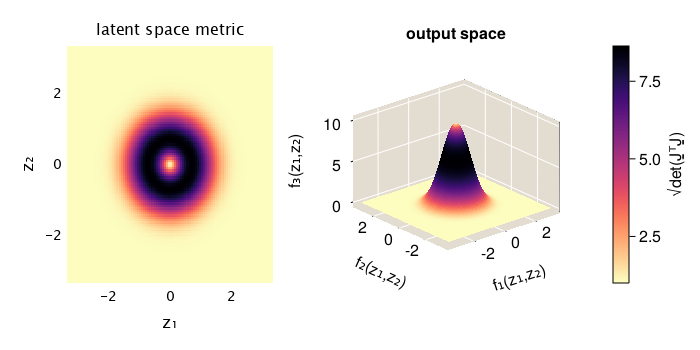

In [4]:
# Initialize figure
fig = Figure(resolution=(2 * 350, 350))

# Add GridLayout
gl = GridLayout(fig[1, 1])

# Add axis for latent space
ax1 = Axis(
    gl[1, 1],
    xlabel="z₁",
    ylabel="z₂",
    title="latent space metric",
)

# Plot metric as a heatmap
hm = heatmap!(
    ax1, z1, z2, manifold_metric, colormap=Reverse(:magma),
)

# Add axis for latent space
ax2 = Axis3(
    gl[1, 2],
    xlabel="f₁(z₁,z₂)",
    ylabel="f₂(z₁,z₂)",
    zlabel="f₃(z₁,z₂)",
    title="output space",
    xypanelcolor="#E3DCD0",
    xzpanelcolor="#E3DCD0",
    yzpanelcolor="#E3DCD0",
    xgridcolor=:white,
    ygridcolor=:white,
    zgridcolor=:white,
)

# Evaluate function on grid
f_output = hcat(vec([f̲(collect(x)) for x in Iterators.product(z1, z2)])...)

# Plot surface
surface!(
    ax2, 
    eachrow(f_output)..., 
    colormap=Reverse(:magma), 
    color=vec(manifold_metric),
    colorrange=(minimum(manifold_metric), maximum(manifold_metric)),
    shading=false,
)

# Add colorbar
Colorbar(fig[:, end+1], hm, label="√det(J̲̲ᵀJ̲̲)") 

# Separate axis
colgap!(gl, 50)

fig

## Approximating geodesics with splines

Let's define a function to compute the energy of a curve $\underline{\gamma}(t)$
on the manifold.

In [5]:
@doc raw"""
    curve_energy(γ, manifold)

Function to compute the (discretized) integral defining the energy of a curve γ
on a Riemmanina manifold. The energy is defined as

    E = ∫ dt ⟨γ̲̇(t), M̲̲ γ̲̇(t)⟩,

where γ̲̇(t) defines the velocity of the parametric curve, and M̲̲ is the
Riemmanian metric. For this function, we use finite differences from the curve
sample points `γ` to compute this integral.

# Arguments
- `γ::AbstractVector{T}`: `d×N` long vector where `d` is the dimension
  of the manifold on which the curve lies and `N` is the number of points along
  the curve. The larger this number, the more accurate the energy estimate will
  be.
- `manifold::Function`: Function defining the Riemmanian manifold on which the
  curve lies.
- `γ̲ₒ::AbstractVector{T}`: Initial position of the curve.
"""
function curve_energy(
    δγ̲::AbstractVector{T}, manifold::Function, γ̲ₒ::AbstractVector{T}
) where T <: Real
    # Define Δt
    Δt = 1 / (length(δγ̲) ÷ length(γ̲ₒ))

    # Reshape δγ̲ to a matrix with each row as a dimension
    δγ̲̲ = reshape(δγ̲, (length(γ̲ₒ), (length(δγ̲) ÷ length(γ̲ₒ))))

    # Reconstruct point values from initial point and δγ̲̲ values
    γ̲̲ = γ̲ₒ .+ cumsum(δγ̲̲, dims=2)

    # Evaluate and return energy
    return (1/2) * sum(
        [
            LinearAlgebra.dot(
                δγ̲̲[:, i], 
                Antibiotic.diffgeo.riemmanian_metric(manifold, γ̲̲[:, i]), 
                δγ̲̲[:, i]
            ) * Δt 
            for i = 1:size(δγ̲̲, 2)
        ]
    ) 
end # function

curve_energy

To minimize the energy, we need to define the gradient in the format required by
`JuMP.jl`.

In [6]:
function ∇curve_energy!(
    ∇E::AbstractVector{T}, 
    δγ̲::AbstractVector{T}, 
    manifold::Function, 
    γ̲ₒ::AbstractVector{T},
    out_dim::Int,
) where T <: AbstractFloat
    # Reshape δγ̲ to a matrix with each row as a dimension
    δγ̲̲ = reshape(δγ̲, length(γ̲ₒ), :)

    # Reconstruct point values from initial point and δγ̲̲ values
    γ̲̲ = γ̲ₒ .+ cumsum(δγ̲̲, dims=2)

    # Initialize array where to save the metric evaluated at each point
    M̲̲ = zeros(T, repeat([length(γ̲ₒ)], 2)..., size(δγ̲̲, 2))

    # Initialize array where to save the derivative of the metric evaluated at
    # each point.
    ∂M̲̲ = zeros(T, repeat([length(γ̲ₒ)], 3)..., size(δγ̲̲, 2))

    # Loop through each γ value
    for k = 1:size(δγ̲̲, 2)
        # Compute metric
        M̲̲[:, :, k] .= Antibiotic.diffgeo.riemmanian_metric(manifold, γ̲̲[:, k])
        # Compute derivative of metric
        ∂M̲̲[:, :, :, k] .= Antibiotic.diffgeo.∂M̲̲∂γ̲(manifold, γ̲̲[:, k], out_dim)
    end # for

    # Define Δt
    Δt = 1 / (size(γ̲̲, 2) - 1)

    # Initialize array to save gradient. Note: The gradient is obviously a
    # vector, but we will store it as an array to keep track of which point
    # along the curve each entry corresponds to
    ∇E_mat = zeros(T, size(δγ̲̲)...)
    
    # Loop through each of the entries
    for k = 1:size(γ̲̲, 2)-1
        # Extract relevant pieces
        _M̲̲ = @view M̲̲[:, :, k]
        _∂M̲̲ = @view ∂M̲̲[:, :, :, k]
        _δγ̲ = @view δγ̲̲[:, k]

        # Compute gradient
        @tensor ∇E_mat[:, k][l] = Δt / 2 * (
            _∂M̲̲[i, j, l] * _δγ̲[i] * _δγ̲[j] +
            2 * _M̲̲[l, i] * _δγ̲[i]
        )
    end # for
    # Update gradient vector in place
    ∇E .= ∇E_mat[:]
end # function

∇curve_energy! (generic function with 1 method)

Let's define a function to initialize the values of a line in latent space
connected at the desired initial and final points.

In [7]:
function curve_init(
    γ_init::Vector{T}, γ_end::Vector{T}, n_points::Int
) where T <: AbstractFloat
    # Initialize array where to return curve
    γ = Matrix{T}(undef, length(γ_init), n_points)
    # Set initial and final points
    γ[:, 1] = γ_init
    γ[:, end] = γ_end

    # Loop through dimensions
    for d = 1:length(γ_init)
        # Interpolate between points
        γ[d, 2:end-1] = LinRange(γ_init[d], γ_end[d], n_points-2)
    end # for

    return diff(γ, dims=2)[:]
end # function

curve_init (generic function with 1 method)

With this initialization function, let's test both of our functions.

In [135]:
# Define points to connect
γ_init = [2.0, -2.0]
γ_end = [-2.0, 1.0]

# Define number of points
n_points = 40

# Initialize curve
δγ̲ₒ = curve_init(γ_init, γ_end, n_points);

First we test the energy.

In [136]:
curve_energy(δγ̲ₒ, f̲, γ_init)

0.16632647591368366

Let's benchmark this function.

In [137]:
BenchmarkTools.@benchmark curve_energy(δγ̲ₒ, f̲, γ_init)

BenchmarkTools.Trial: 5740 samples with 1 evaluation.
 Range (min … max):  821.167 μs …  26.867 ms  ┊ GC (min … max): 0.00% … 96.17%
 Time  (median):     842.875 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   869.797 μs ± 762.660 μs  ┊ GC (mean ± σ):  2.57% ±  2.84%

     ▃▄▄▇████▇▆▅▄▃▂▂                                             
  ▃▅▇███████████████▇▇▇▆▅▅▄▄▄▄▃▃▃▃▃▃▃▂▃▂▂▂▂▂▃▂▂▂▂▂▁▂▂▂▂▂▂▂▂▂▂▁▂ ▄
  821 μs           Histogram: frequency by time          937 μs <

 Memory estimate: 272.66 KiB, allocs estimate: 8009.

Next, we test the gradient.

In [11]:
# Initialize vector where to save gradient
∇E = similar(δγ̲ₒ)

# Compute gradient
∇curve_energy!(∇E, δγ̲ₒ, f̲, γ_init, 3)

48-element Vector{Float64}:
  0.0
  0.0
 -0.007933070226739987
  0.003982702703986561
 -0.008056912120410296
  0.004126886272602457
 -0.008587124053771208
  0.004796541869361461
 -0.010423384068684566
  0.007365067852770433
  ⋮
  0.0012857471946012607
 -0.027316530180166814
  0.004196023081000339
 -0.01404371995684936
  0.004387060427783002
 -0.009448049456396742
  0.004145433059519945
  0.0
  0.0

The function seems to be working as well. Let's also benchmark this function.

In [12]:
BenchmarkTools.@benchmark ∇curve_energy!(∇E, δγ̲ₒ, f̲, γ_init, 3)

BenchmarkTools.Trial: 2836 samples with 1 evaluation.
 Range (min … max):  1.630 ms … 26.049 ms  ┊ GC (min … max): 0.00% … 92.14%
 Time  (median):     1.678 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   1.762 ms ±  1.333 ms  ┊ GC (mean ± σ):  4.22% ±  5.19%

    ▄▄▂▁▁▂▆▇█▅▃▃                                              
  ▃██████████████▇▆▄▃▄▃▃▃▂▃▂▂▂▃▂▃▂▃▃▂▃▂▂▂▃▂▂▃▂▂▂▂▂▂▂▁▂▂▂▂▂▂▂ ▄
  1.63 ms        Histogram: frequency by time        1.91 ms <

 Memory estimate: 916.17 KiB, allocs estimate: 16988.

Let's register our functions to be used with Jump. The arguments to register
are:

1. The model for which the functions are registered.
2. A Julia symbol object which serves as the name of the user-defined function
   in JuMP expressions.
3. The number of input arguments that the function takes.
4. The Julia method which computes the function
5. A flag to instruct JuMP to compute exact gradients automatically.

In [138]:
# Define function with fixed manifold
Energy(δγ̲::T...) where T <: AbstractFloat = curve_energy(collect(δγ̲), f̲, γ_init)
∂̲Energy!(
    ∇E::AbstractVector{T}, δγ̲::T...
) where T <: AbstractFloat = ∇curve_energy!(
    ∇E, collect(δγ̲), f̲, γ_init, 3
)

# Initialize a JuMP model
# model = JuMP.Model(Ipopt.Optimizer)


# Initialize a JuMP model
model = JuMP.Model(NLopt.Optimizer)
# Set algorithm for optimizer
# JuMP.set_optimizer_attribute(model, "algorithm", :AUGLAG)
# JuMP.set_optimizer_attribute(model, "local_optimizer", :LD_LBFGS)
JuMP.set_optimizer_attribute(model, "algorithm", :LD_SLSQP)

model

A JuMP Model
Feasibility problem with:
Variables: 0
Model mode: AUTOMATIC
CachingOptimizer state: EMPTY_OPTIMIZER
Solver name: NLopt

Let's register the model

In [139]:
# Register model
JuMP.register(model, :energy, length(δγ̲ₒ), Energy, ∂̲Energy!; autodiff=false)

Next, we define the variables for our optimization.

In [140]:
# Register variables
JuMP.@variable(model, δγ[1:length(δγ̲ₒ)])

78-element Vector{JuMP.VariableRef}:
 δγ[1]
 δγ[2]
 δγ[3]
 δγ[4]
 δγ[5]
 δγ[6]
 δγ[7]
 δγ[8]
 δγ[9]
 δγ[10]
 ⋮
 δγ[70]
 δγ[71]
 δγ[72]
 δγ[73]
 δγ[74]
 δγ[75]
 δγ[76]
 δγ[77]
 δγ[78]

As well as the constraints on each dimension.

In [141]:
# Define dimensionality of latent space
d = length(γ_init)

# Set constraints for each dimension
# JuMP.@NLconstraint(model, c[i=1:d], sum(δγ[i:d:end]) == (γ_end .- γ_init)[i])

JuMP.@NLconstraint(
    model, 
    c[i=1:d], 
    sum(δγ[j] for j = i:d:length(δγ̲ₒ)) == (γ_end .- γ_init)[i]
)

2-element Vector{JuMP.NonlinearConstraintRef{JuMP.ScalarShape}}:
 (δγ[1] + δγ[3] + δγ[5] + δγ[7] + δγ[9] + δγ[11] + δγ[13] + δγ[15] + δγ[17] + δγ[19] + δγ[21] + δγ[23] + δγ[25] + δγ[27] + δγ[29] + δγ[31] + δγ[33] + δγ[35] + δγ[37] + δγ[39] + δγ[41] + δγ[43] + δγ[45] + δγ[47] + δγ[49] + δγ[51] + δγ[53] + δγ[55] + δγ[57] + δγ[59] + δγ[61] + δγ[63] + δγ[65] + δγ[67] + δγ[69] + δγ[71] + δγ[73] + δγ[75] + δγ[77]) - -4.0 = 0
 (δγ[2] + δγ[4] + δγ[6] + δγ[8] + δγ[10] + δγ[12] + δγ[14] + δγ[16] + δγ[18] + δγ[20] + δγ[22] + δγ[24] + δγ[26] + δγ[28] + δγ[30] + δγ[32] + δγ[34] + δγ[36] + δγ[38] + δγ[40] + δγ[42] + δγ[44] + δγ[46] + δγ[48] + δγ[50] + δγ[52] + δγ[54] + δγ[56] + δγ[58] + δγ[60] + δγ[62] + δγ[64] + δγ[66] + δγ[68] + δγ[70] + δγ[72] + δγ[74] + δγ[76] + δγ[78]) - 3.0 = 0

Let's set the initial values for the optimization.

In [142]:
# Loop through variables
for (i, δ) in enumerate(δγ̲ₒ)
    JuMP.set_start_value(δγ[i], δ)
end # for

Finally, we set the objective of minimizing the energy function.

In [143]:
# Set objective
JuMP.@NLobjective(model, Min, energy(δγ...))

In [144]:
JuMP.optimize!(model)

In [119]:
JuMP.solution_summary(model)

* Solver : NLopt

* Status
  Result count       : 1
  Termination status : LOCALLY_SOLVED
  Message from the solver:
  "FTOL_REACHED"

* Candidate solution (result #1)
  Primal status      : FEASIBLE_POINT
  Dual status        : NO_SOLUTION
  Objective value    : 2.42682e-02
  Dual objective value : 0.00000e+00

* Work counters
  Solve time (sec)   : 1.98188e+00


In [122]:
JuMP.objective_value(model)

0.024268192811307758

2×25 Matrix{Float64}:
  2.0   1.83471   1.61907   1.42597  …  -1.59369   -1.74059  -2.0
 -2.0  -1.89893  -1.7751   -1.67758     -0.300189  -0.17981  -2.22045e-16

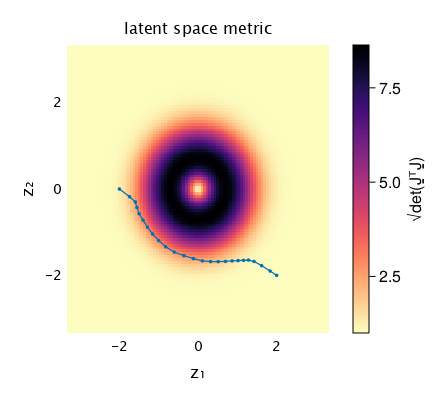

In [134]:
# Construct solution from differences
γ = hcat(γ_init, γ_init .+  cumsum(reshape(JuMP.value.(δγ), 2, :), dims=2))

# Initialize figure
fig = Figure(resolution=(1.1 * 400, 400))

# Add GridLayout
gl = GridLayout(fig[1, 1])

# Add ax_inputis for latent space
ax_input = Axis(
    gl[1, 1],
    xlabel="z₁",
    ylabel="z₂",
    title="latent space metric"
)

# Plot metric as a heatmap
hm = heatmap!(
    ax_input, z1, z2, manifold_metric, colormap=Reverse(:magma),
)

# Add initial guess
scatterlines!(ax_input, eachrow(γ)..., markersize=5)
# Add optimized curve
# scatterlines!(ax_input, eachrow(γ_opt)..., markersize=5, color=:red)

# Add colorbar
Colorbar(fig[:, end+1], hm, label="√det(J̲̲ᵀJ̲̲)") 

fig